# Wind power modelling assignment

    Name: Leon Correa
    Student Number: e122676

This notebook explains the modelling process to obtain and plot the wind power curves based on wind speed statistical data gathered from the Finnish Meteorogical Institute and additionally shows a practical approach to calculate and plot the power obtained from a given wind turbine using the previously mentioned statistical data. 

The modelling is done using the NumPy for computations, Pandas for data analysis and Matplotlib for plotting.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The downloaded data from the Finnish meteorogical institute contains a .csv file with wind speed measurements for a day with a time interval of 10 minutes.

Finnish Meteorogical Institute:
https://en.ilmatieteenlaitos.fi/download-observations

Wind speed data:
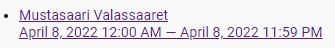

The data is read, parsed, cleaned, described and plotted.

In [2]:
# Read the wind speed data
df_ws = pd.read_csv('csv-399a4d4b-86a2-4075-955e-9809e4134ca8.csv', parse_dates={ 'Date': ['Year', 'm', 'd','Time'] }, index_col = 0, skipinitialspace=False)
df_ws = df_ws.drop('Time zone',1)
df_ws['Wind speed (m/s)'].fillna(method = 'ffill', inplace = True)
df_ws.describe()

C:\Users\FILECOR\AppData\Local\Temp/ipykernel_33460/2495050630.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_ws = df_ws.drop('Time zone',1)


,Wind speed (m/s)
count,144.000000
mean,8.932639
std,4.783185
min,2.600000
25%,5.175000
50%,7.200000
75%,12.100000
max,19.100000


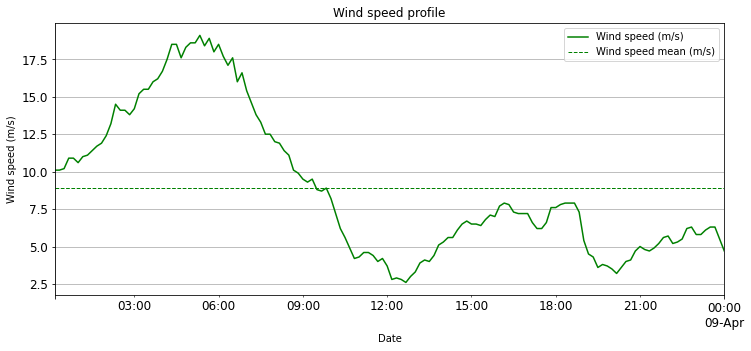

In [3]:
# Plot Wind speed profile
ax=df_ws.plot( y='Wind speed (m/s)',
           kind = 'line',
           figsize=(12,5),
           grid=True,
           fontsize=12,
           ylabel='Wind speed (m/s)',
           title='Wind speed profile',
           color='g')
ax.axhline(y=df_ws['Wind speed (m/s)'].mean(), color='g', linestyle='--', lw=1, label='Wind speed mean (m/s)')
plt.legend()

The wind turbine selected to be analyzed is a V112/3000 from the manufacturer Vestas.

Datasheet & Power curve from the free sample: 
https://www.thewindpower.net/turbine_en_413_vestas_v112-3000.php

The power coefficient curve can also be found from the following python library:
https://github.com/wind-python/windpowerlib

For learning purposes this notebook estimates the power coefficient curve rather than using the existing data.

In [4]:
# Vestas V112/3000 Wind Turbine parameters
nominal_power = 3000 # kilowatts
cut_in_wind_speed = 3.5 # meters per second
rated_wind_speed = 15.5 # meters per second
cut_out_wind_speed = 25 # meters per second
rotor_diameter = 112 # meters
rotor_area = (0.25)*np.pi*(rotor_diameter**2) # squared-meters

The wind turbine power curve needs to be plotted from the .csv file that contains the wind turbine power measurements at different wind speeds, also the wind turbine power coefficient is calculated with this information. For this matter, the data is read, parsed, cleaned and described. Additionally two functions are defined to calculate the wind power and the wind turbine power coefficient.

In [5]:
# Read Wind Turbine power curve from manufacturer
df_wtm = pd.read_csv('V112-3000_Power_Curve.csv', skipinitialspace=False)
df_wtm = df_wtm.dropna()
df_wtm.describe()

,Wind speed (m/s),Power (kW)
count,71.000000,71.000000
mean,17.500000,1349.380282
std,10.319884,1374.382473
min,0.000000,0.000000
25%,8.750000,0.000000
50%,17.500000,737.000000
75%,26.250000,3000.000000
max,35.000000,3000.000000


In [6]:
# Parameters for calculation
air_density = 1.293 # kilograms per cubic-meters

# Define the wind power function
def Wpower_calc(wind_speed):
    constant_wp_eq = 0.5*air_density*rotor_area
    Wpower = float(constant_wp_eq*wind_speed**3)*(1/1000) # Converted to KiloWatts
    return(Wpower)

# Define the wind turbine power coefficient function
def WTcp_calc(wind_speed, WTpower):
    constant_cp_eq = (2/(air_density*rotor_area))*1000 # Converted to Watts to make cp adimmensional
    if wind_speed != 0:
        WTcp = float(constant_cp_eq*(WTpower/(wind_speed**3)))
    else:
        WTcp = 0
    return(WTcp)

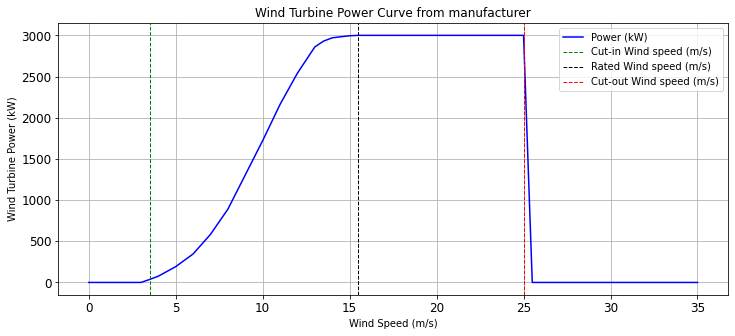

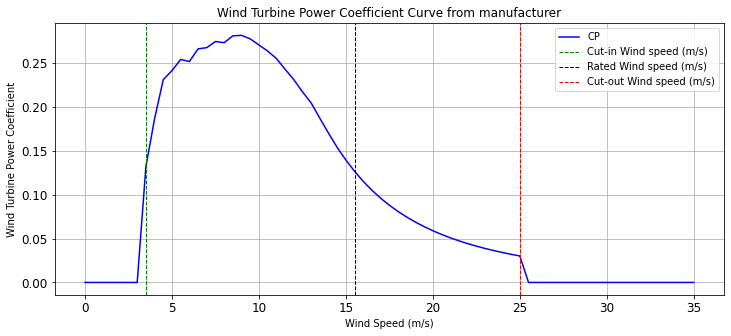

In [7]:
# Calculate the wind turbine power coefficient
df_wtm['CP'] = df_wtm[['Wind speed (m/s)','Power (kW)']].apply(lambda x: WTcp_calc(*x), axis=1)

# Plot the wind turbine power curve from manufacturer data
ax = df_wtm.plot(x ='Wind speed (m/s)', y='Power (kW)',
           kind = 'line',
           figsize=(12,5),
           grid=True,
           fontsize=12,
           ylabel='Wind Turbine Power (kW)',
           xlabel='Wind Speed (m/s)',
           title='Wind Turbine Power Curve from manufacturer',
           color='b')
ax.axvline(x=cut_in_wind_speed, color='g', linestyle='--', lw=1, label='Cut-in Wind speed (m/s)')
ax.axvline(x=rated_wind_speed, color='k', linestyle='--', lw=1, label='Rated Wind speed (m/s)')
ax.axvline(x=cut_out_wind_speed, color='r', linestyle='--', lw=1, label='Cut-out Wind speed (m/s)')
plt.legend()

# Plot the wind turbine power coefficient curve from manufacturer data
ax=df_wtm.plot(x ='Wind speed (m/s)', y='CP',
           kind = 'line',
           figsize=(12,5),
           grid=True,
           fontsize=12,
           ylabel='Wind Turbine Power Coefficient',
           xlabel='Wind Speed (m/s)',
           title='Wind Turbine Power Coefficient Curve from manufacturer',
           color='b')
ax.axvline(x=cut_in_wind_speed, color='g', linestyle='--', lw=1, label='Cut-in Wind speed (m/s)')
ax.axvline(x=rated_wind_speed, color='k', linestyle='--', lw=1, label='Rated Wind speed (m/s)')
ax.axvline(x=cut_out_wind_speed, color='r', linestyle='--', lw=1, label='Cut-out Wind speed (m/s)')
plt.legend()

With the wind power function and the diameter of the wind turbine it is possible to estimate the wind power using the wind speed data previously downloaded and stored in the dataframe.

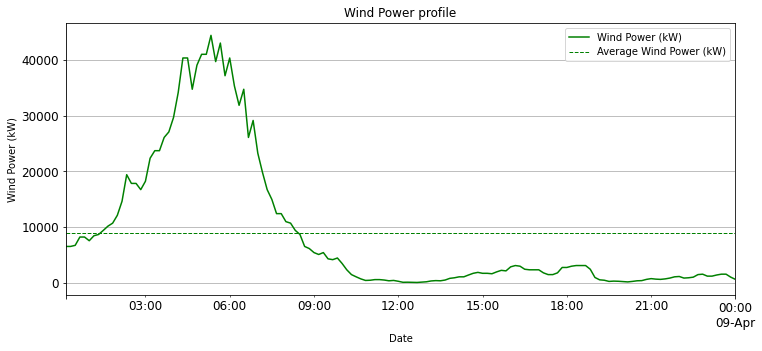

In [8]:
# Estimate the wind power without the cp factor 
df_ws['Wind Power (kW)'] = df_ws['Wind speed (m/s)'].apply(Wpower_calc)

# Append the results to the wind speed dataframe
ax=df_ws.plot( y='Wind Power (kW)',
           kind = 'line',
           figsize=(12,5),
           grid=True,
           fontsize=12,
           ylabel='Wind Power (kW)',
           title='Wind Power profile',
           color='g')
ax.axhline(y=df_ws['Wind Power (kW)'].mean(), color='g', linestyle='--', lw=1, label='Average Wind Power (kW)')
plt.legend()

The next step is to estimate how much power will be produced by the wind turbine considering the wind speed data and the wind turbine power coefficient. To estimate it we need to estimate the power coefficient in function of the wind speed for the region II of the wind turbine power curve which correspond to the region covered when the wind speed is greater than the wind turbine cut-in wind speed and lesser than the wind turbine rated wind speed.

To estimate the power coefficient function a curve is fitted with the manufacturer data using a polynomial function:
https://www.statology.org/curve-fitting-python/

Several theoretical estimation methods exist for this step, however,this approach is a practical one.

C:\Users\FILECOR\AppData\Local\Temp/ipykernel_33460/121211365.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_cp = df_cp.drop('Power (kW)',1)


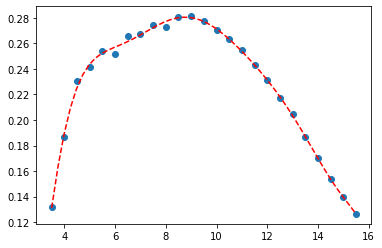

Fitted curve R2 is: {'r_squared': 0.9965594836150629}

Estimated wind turbine power coefficient equation for region II of the wind turbine power curve:

            9             8             7            6           5
-3.068e-08 x + 2.665e-06 x - 9.985e-05 x + 0.002109 x - 0.02751 x
          4         3         2
 + 0.228 x - 1.188 x + 3.689 x - 5.965 x + 3.711


In [9]:
# Slice the datafram for the wind turbine power coefficient in the region II
df_cp = df_wtm[(df_wtm['Wind speed (m/s)'] >= cut_in_wind_speed)&(df_wtm['Wind speed (m/s)'] <= rated_wind_speed)]
df_cp = df_cp.drop('Power (kW)',1)

# fit a polynomial model of degree 9 with the sliced dataframe
cp = np.poly1d(np.polyfit(df_cp['Wind speed (m/s)'], df_cp['CP'], 9))

# create a scatterplot to visualize the manufacturer data and the fitted curve
polyline = np.linspace(cut_in_wind_speed, rated_wind_speed, 50)
plt.scatter(df_cp['Wind speed (m/s)'], df_cp['CP'])

# add fitted polynomial lines to scatterplot 
plt.plot(polyline, cp(polyline), '--',color='r')
plt.show()

#define function to calculate adjusted r-squared
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return results

# calculated adjusted R-squared of the model
r2_cp = adjR(df_cp['Wind speed (m/s)'], df_cp['CP'], 9)
print('Fitted curve R2 is:',r2_cp)
print()
print('Estimated wind turbine power coefficient equation for region II of the wind turbine power curve:')
print()
print(cp)

The wind turbine power can be estimated with the fitted curve for the power coefficient and the wind speed information

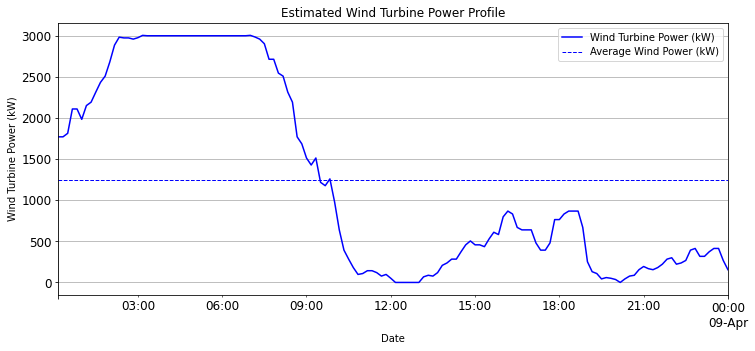

In [10]:
# Estimate the power for the different regions and merged them together in a single dataframe
df_ws['RI'] = df_ws['Wind speed (m/s)'].apply(lambda x: 0 if x < cut_in_wind_speed else 1)
df_ws['RII'] = df_ws['Wind speed (m/s)'].apply(lambda x: (1/2)*air_density*rotor_area*(x**3)*(1/1000)*cp(x) if x >= cut_in_wind_speed and x < rated_wind_speed else 1)
df_ws['RIII'] = df_ws['Wind speed (m/s)'].apply(lambda x: nominal_power  if x >= rated_wind_speed and x < cut_out_wind_speed else 1)
df_ws['RIV'] = df_ws['Wind speed (m/s)'].apply(lambda x: 0  if x >= cut_out_wind_speed else 1)
df_ws['Wind Turbine Power (kW)'] = df_ws['RI']*df_ws['RII']*df_ws['RIII']*df_ws['RIV']

# Plot the wind turbine power 
ax=df_ws.plot( y='Wind Turbine Power (kW)',
           kind = 'line',
           figsize=(12,5),
           grid=True,
           fontsize=12,
           ylabel='Wind Turbine Power (kW)',
           title='Estimated Wind Turbine Power Profile',
           color='b')
ax.axhline(y=df_ws['Wind Turbine Power (kW)'].mean(), color='b', linestyle='--', lw=1, label='Average Wind Power (kW)')
plt.legend()

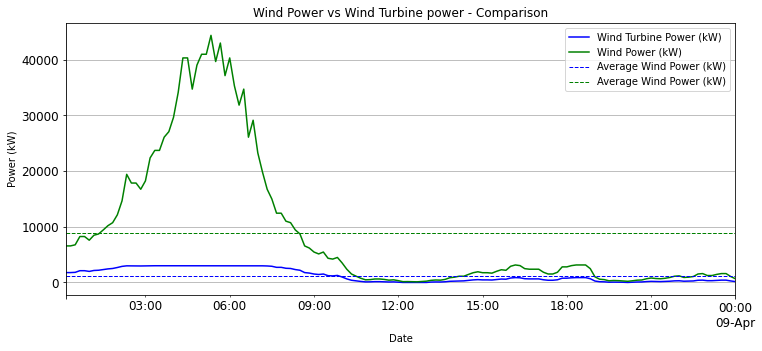

In [11]:
# Plot the wind turbine power 
ax=df_ws.plot( y='Wind Turbine Power (kW)',
           kind = 'line',
           figsize=(12,5),
           grid=True,
           fontsize=12,
           color='b')

# Plot the wind power 
df_ws.plot( ax=ax,y='Wind Power (kW)',
           kind = 'line',
           figsize=(12,5),
           grid=True,
           fontsize=12,
           ylabel='Power (kW)',
           title='Wind Power vs Wind Turbine power - Comparison',
           color='g')

ax.axhline(y=df_ws['Wind Turbine Power (kW)'].mean(), color='b', linestyle='--', lw=1, label='Average Wind Power (kW)')
ax.axhline(y=df_ws['Wind Power (kW)'].mean(), color='g', linestyle='--', lw=1, label='Average Wind Power (kW)')
plt.legend()

Some other consulted references:

*Yves-Marie Saint-Drenan, Romain Besseau, Malte Jansen, Iain Staffell, Alberto Troccoli, Laurent Dubus, Johannes Schmidt, Katharina Gruber, Sofia G. Simões, Siegfried Heier,
A parametric model for wind turbine power curves incorporating environmental conditions,
Renewable Energy,
Volume 157,
2020,
Pages 754-768,
ISSN 0960-1481,
https://doi.org/10.1016/j.renene.2020.04.123.
(https://www.sciencedirect.com/science/article/pii/S0960148120306613)

*Wind energy physics and resource assesment with python:
https://towardsdatascience.com/wind-energy-physics-and-resource-assessment-with-python-789a0273e697